### 10.4.1 切分數據集與交叉驗證

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=10)
X_train,X_test=train_test_split(X,test_size=0.3,random_state=10)

In [2]:
from sklearn.cross_validation import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
import numpy as np
from sklearn.svm import SVC

iris = load_iris()
X_train,X_test,y_train,y_test=train_test_split(iris.data,iris.target,
                                               test_size=0.3,random_state=10)
num = 5 # 5折交叉驗證
train_preds = np.zeros(X_train.shape[0]) # 用於保存預測結果
test_preds = np.zeros((X_test.shape[0], num))
kf = KFold(len(X_train), n_folds = num, shuffle=True, random_state=0)
for i, (train_index, eval_index) in enumerate(kf):
    clf = SVC(C=1, gamma=0.125, kernel='rbf')
    clf.fit(X_train[train_index], y_train[train_index])
    train_preds[eval_index] += clf.predict(X_train[eval_index])
    test_preds[:,i] = clf.predict(X_test)
print(accuracy_score(y_train, train_preds)) # 返回結果: 0.971428571429
print(test_preds.mean(axis=1))

0.9714285714285714
[1.  2.  0.  1.  0.  1.  1.6 1.  0.  1.  1.  2.  1.  0.  0.  2.  1.  0.
 0.  0.  2.  2.  2.  0.  1.  0.  1.  1.  1.  2.  1.  1.  2.  2.  2.  0.
 2.  2.  2.  2.  0.  0.  1.  0.  1. ]


/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from sklearn.model_selection import cross_val_score # python 3使用
# from sklearn.cross_validation import cross_val_score # python 2 使用
print(cross_val_score(clf, iris.data, iris.target).mean())

0.9734477124183006


### 10.4.2 模型調參

In [4]:
# 網格搜索
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_iris

iris = load_iris()
model = SVC(random_state=1)
param_grid = {'kernel':('linear', 'rbf'), 'C':[1, 2, 4], # 制定參數範圍
              'gamma':[0.125, 0.25, 0.5 ,1, 2, 4]}
gs = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', 
                  cv=10, n_jobs=-1)
gs = gs.fit(iris.data, iris.target)
y_pred = gs.predict(iris.data)  # 預測
print(gs.best_score_)
print(gs.best_params_)

0.98
{'C': 1, 'gamma': 0.125, 'kernel': 'rbf'}


In [5]:
# Hyperopt
from hyperopt import fmin, tpe, hp, Trials
trials = Trials()
best = fmin(
    fn=lambda x: (x-1)**2, # 最小化目標，如誤差函數
    space=hp.uniform('x', -10, 10), # 定義搜索空間, 名稱爲x，範圍-10~10
    algo=tpe.suggest, # 指定搜索算法
    trials=trials, # 保存每次迭代的具體信息
    max_evals=50) # 評估次數
print(best) # 返回結果：{'x': 0.980859461591201}
for t in trials.trials:
    print(t['result'])

100%|██████████| 50/50 [00:00<00:00, 405.64it/s, best loss: 0.0019107133706819787]
{'x': 0.9562882925215455}
{'loss': 4.991838917081291, 'status': 'ok'}
{'loss': 68.790429559662, 'status': 'ok'}
{'loss': 33.180512321437924, 'status': 'ok'}
{'loss': 79.99678138957901, 'status': 'ok'}
{'loss': 16.276785401662448, 'status': 'ok'}
{'loss': 0.0019107133706819787, 'status': 'ok'}
{'loss': 22.099544970541615, 'status': 'ok'}
{'loss': 20.095125710737545, 'status': 'ok'}
{'loss': 16.986418295445425, 'status': 'ok'}
{'loss': 8.948088405025153, 'status': 'ok'}
{'loss': 56.763701072666564, 'status': 'ok'}
{'loss': 23.76261989212823, 'status': 'ok'}
{'loss': 13.313566851253062, 'status': 'ok'}
{'loss': 25.213708960253175, 'status': 'ok'}
{'loss': 51.624201694350155, 'status': 'ok'}
{'loss': 22.41120462617784, 'status': 'ok'}
{'loss': 6.757529380445592, 'status': 'ok'}
{'loss': 49.02157994195912, 'status': 'ok'}
{'loss': 5.565611897090952, 'status': 'ok'}
{'loss': 105.9409053643773, 'status': 'ok'}


In [6]:
from sklearn.datasets import load_iris
from sklearn.cross_validation import cross_val_score
from hyperopt import hp,STATUS_OK,Trials,fmin,tpe
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

def f(params): # 定義評價函數
    t = params['type']
    del params['type']
    if t == 'svm':
        clf = SVC(**params)
    elif t == 'randomforest':
        clf = RandomForestClassifier(**params)
    else:
        return 0
    acc = cross_val_score(clf, iris.data, iris.target).mean() 
    return {'loss': -acc, 'status': STATUS_OK} # 求最小值:準確率加負號

iris=load_iris()
space = hp.choice('classifier_type', [ # 定義可選參數
    {
        'type': 'svm',
        'C': hp.uniform('C', 0, 10.0),
        'kernel': hp.choice('kernel', ['linear', 'rbf']),
        'gamma': hp.uniform('gamma', 0, 20.0)
    },
    {
        'type': 'randomforest',
        'max_depth': hp.choice('max_depth', range(1,20)),
        'max_features': hp.choice('max_features', range(1,5)),
        'n_estimators': hp.choice('n_estimators', range(1,20)),
        'criterion': hp.choice('criterion', ["gini", "entropy"])
    }
])
best = fmin(f, space, algo=tpe.suggest, max_evals=100)
print('best:',best) 

  2%|▏         | 2/100 [00:00<00:07, 12.70it/s, best loss: -0.9599673202614379]

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


100%|██████████| 100/100 [00:03<00:00, 30.52it/s, best loss: -0.9869281045751634]
best: {'C': 1.0107348688324413, 'classifier_type': 0, 'gamma': 2.3175901182486336, 'kernel': 0}


### 10.4.3 學習曲線和驗證曲線

In [7]:
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

def draw_curve(params, train_score, test_score):
    train_mean =  np.mean(train_score,axis=1) # 均值
    train_std = np.std(train_score,axis=1) # 標準差
    test_mean = np.mean(test_score,axis=1)
    test_std=np.std(test_score,axis=1)
    plt.plot(params,train_mean,'--',color = 'g',label = 'training')
    plt.fill_between(params,train_mean+train_std,train_mean-train_std, 
                     alpha=0.2,color='g') # 以半透明方式繪圖區域
    plt.plot(params,test_mean,'o-',color = 'b',label = 'testing')
    plt.fill_between(params,test_mean+test_std,test_mean-test_std, 
                     alpha=0.2,color='b')
    plt.grid() # 顯示網格
    plt.legend() # 顯示圖例文字
    plt.ylim(0.5,1.05) # 設定y軸顯示範圍
    plt.show()

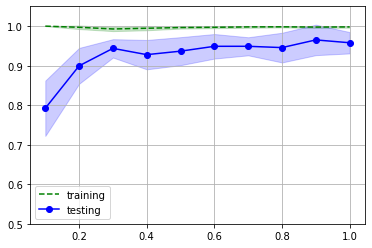

In [8]:
from sklearn.model_selection import learning_curve
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

clf = RandomForestClassifier()
params = np.linspace(0.1,1.0,10) # 從0.1到1，切分成10份
train_sizes,train_score,test_score = learning_curve(clf,X,y,
                            train_sizes=params,
                            cv=10,scoring='accuracy') # 10折交叉驗證
draw_curve(params, train_score, test_score)

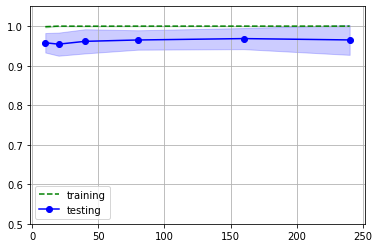

In [9]:
from sklearn.model_selection import validation_curve
params = [10,20,40,80,160,240]
train_score,test_score = validation_curve(RandomForestClassifier(),
                     X,y,param_name='n_estimators',cv=10,scoring='accuracy',
                     param_range=params)
draw_curve(params, train_score, test_score)
